# Introduction

The data has been taken from Kaggle: https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv

In this document I am going to create a content-based recommendation system that recommends movies based on their metadata.

At first, I import tha data and preprocess it. The preprocessing involves extracting necessary information from dictionaries in several columns and stripping them from unneeded symbols.

Then comes the exploratory part, where I explore the data to answer some of my questions, using dataframe slicing to obtain results and matplotlib to have their visual representation. 

After that I build a model by vectorizing the metadata of the movies and obtaining the most similar movies with cosine similarity.

In the end, I summarize the knowledge I've obtained when researching this topic by presenting criterias of a recommendation system evaluation, and explaining how the content-based recommendation system fits into them.

# Importing libraries and data

In [1]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
seaborn.set()

movies_source = pd.read_csv('tmdb_5000_movies.csv')
credits_source = pd.read_csv('tmdb_5000_credits.csv')

In [2]:
movies = movies_source.copy()
credits = credits_source.copy()

credits.rename(columns={'movie_id':'id'},inplace=True)
movies = movies.merge(credits,on='id')

In [3]:
pd.options.display.max_columns=None
movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": "

This data looks fairly clean. The only preparation I need to do is to extract useful values from columns with dictionary format.

# Preprocessing

In [4]:
movies.isnull().any(axis=0)

budget                  False
genres                  False
homepage                 True
id                      False
keywords                False
original_language       False
original_title          False
overview                 True
popularity              False
production_companies    False
production_countries    False
release_date             True
revenue                 False
runtime                  True
spoken_languages        False
status                  False
tagline                  True
title_x                 False
vote_average            False
vote_count              False
title_y                 False
cast                    False
crew                    False
dtype: bool

The only columns that have missing values are "homepage", "overview", "release_date", "runtime" and "tagline". I'm not planning to use them in the model, so I will keep them as they are.

In [5]:
features = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']
for feature in features:
    movies[feature] = movies[feature].apply(ast.literal_eval)

The "ast.literal_eval" function transforms string objects into dictionaries. Now I can extract information I need from them.

In [6]:
def get_director(crew):
    for member in crew:
        if member['job'] == 'Director':
            return member['name']
    #if the director is not found - return NaN
    return np.nan
   
movies['director'] = movies['crew'].apply(get_director)
movies = movies.drop('crew',axis=1)

The most important filming crew member for my model is the director, so I need to get the director for every movie in the dataset.

In [7]:
def get_main_cast(cast):
    main_cast=[]
    for i in cast:
        main_cast.append(i['name'])
        if len(main_cast) == 3:
            break
    return main_cast

movies['main_cast'] = movies['cast'].apply(get_main_cast)
movies = movies.drop('cast',axis=1)

I would also need 3 main actors from each movie. If there are less than 3 actors stated in the movie discription, I will keep all of them.

In [8]:
def get_tags(title):
    tags=[]
    for tag in title:
        tags.append(tag['name'])
    return tags

features = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
for i in features:
    movies[i] = movies[i].apply(get_tags)

The rest of the columns to clean share similar structure, so they can be preprocessed all at once.

In [9]:
def clean_data(x):
    #for cells that have more than 1 word in them, like "main_cast", this function is applied
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #if a cell has only 1 word in it, like "director", this function is applied
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages', 'main_cast', 'director']
for i in features:
    movies[i] = movies[i].apply(clean_data)

I also need to strip the newly cleaned columns from spaces and convert all letters into lowercase. If the spaces are kept, the model would count the Tom of "Tom Hanks" and "Tom Cruise" as the same.

In [10]:
cols_to_drop=['homepage','original_language','production_countries','status','title_x','title_y']
movies = movies.drop(cols_to_drop,axis=1)
movies

,budget,genres,id,keywords,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,director,main_cast
0,237000000,"[action, adventure, fantasy, sciencefiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[ingeniousfilmpartners, twentiethcenturyfoxfil...",2009-12-10,2787965087,162.0,"[english, español]",Enter the World of Pandora.,7.2,11800,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]"
1,300000000,"[adventure, fantasy, action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[waltdisneypictures, jerrybruckheimerfilms, se...",2007-05-19,961000000,169.0,[english],"At the end of the world, the adventure begins.",6.9,4500,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]"
2,245000000,"[action, adventure, crime]",206647,"[spy, basedonnovel, secretagent, sequel, mi6, ...",Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[columbiapictures, danjaq, b24]",2015-10-26,880674609,148.0,"[français, english, español, italiano, deutsch]",A Plan No One Escapes,6.3,4466,sammendes,"[danielcraig, christophwaltz, léaseydoux]"
3,250000000,"[action, crime, drama, thriller]",49026,"[dccomics, crimefighter, terrorist, secretiden...",The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[legendarypictures, warnerbros., dcentertainme...",2012-07-16,1084939099,165.0,[english],The Legend Ends,7.6,9106,christophernolan,"[christianbale, michaelcaine, garyoldman]"
4,260000000,"[action, adventure, sciencefiction]",49529,"[basedonnovel, mars, medallion, spacetravel, p...",John Carter,"John Carter is a war-weary, former military ca...",43.926995,[waltdisneypictures],2012-03-07,284139100,132.0,[english],"Lost in our world, found in another.",6.1,2124,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[action, crime, thriller]",9367,"[unitedstates–mexicobarrier, legs, arms, paper...",El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,[columbiapictures],1992-09-04,2040920,81.0,[español],"He didn't come looking for trouble, but troubl...",6.6,238,robertrodriguez,"[carlosgallardo, jaimedehoyos, petermarquardt]"
4799,9000,"[comedy, romance]",72766,[],Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],2011-12-26,0,85.0,[],A newlywed couple's honeymoon is upended by th...,5.9,5,edwardburns,"[edwardburns, kerrybishé, marshadietlein]"
4800,0,"[comedy, drama, romance, tvmovie]",231617,"[date, loveatfirstsight, narration, investigat...","Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[frontstreetpictures, museentertainmententerpr...",2013-10-13,0,120.0,[english],NaN,7.0,6,scottsmith,"[ericmabius, kristinbooth, crystallowe]"
4801,0,[],126186,[],Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],2012-05-03,0,98.0,[english],A New Yorker in Shanghai,5.7,7,danielhsia,"[danielhenney, elizacoupe, billpaxton]"


Lastly, I would like to drop the coulms that do not contain any useful information.

# Exploratory analysis

In this section I want to answer some of the questions that interest me about the data, that may not be particularly useful for building a model. 

My questions are:
- What are the most poular genres, actors and movies?
- Which production companies made the most movies?
- What are the most expensive and most profitable movies in this dataset?
- What is the ratings distribution?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

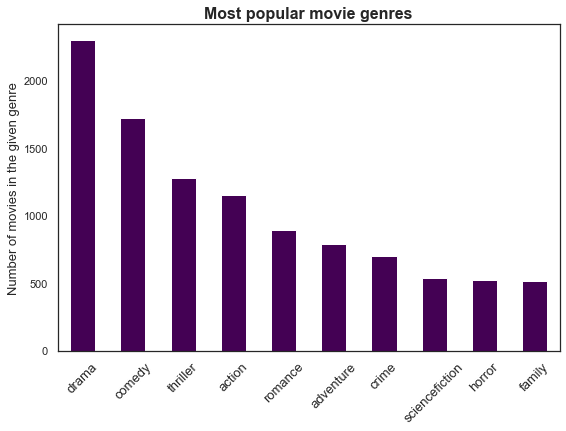

In [11]:
seaborn.set_style('white')
plt.figure(figsize = (9, 6))
plt.title("Most popular movie genres", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of movies in the given genre", fontsize = 13 ) 
movies['genres'].explode().value_counts().head(10).plot.bar(cmap = 'viridis')
plt.xticks(rotation=45, fontsize=13)

The most popular genres here seem to be drama and comedy. They make up for 47% and 35% of all movies present here.

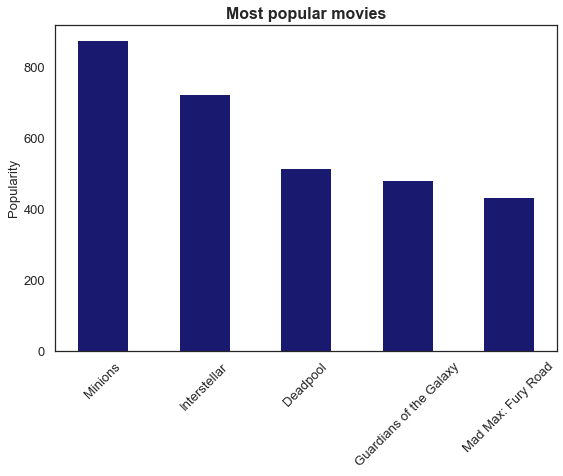

In [12]:
seaborn.set_style('white')
plt.figure(figsize = (9, 6))
plt.bar(x=movies.sort_values('popularity', ascending=False).head(5)['original_title'],
        height=movies.sort_values('popularity', ascending=False).head(5)['popularity'], 
        color='midnightblue', 
        width = 0.5)
plt.title("Most popular movies", fontsize = 16, fontweight = "bold")
plt.ylabel("Popularity", fontsize = 13 ) 
plt.yticks(fontsize = 13)
plt.xticks(rotation = 45, fontsize = 13)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

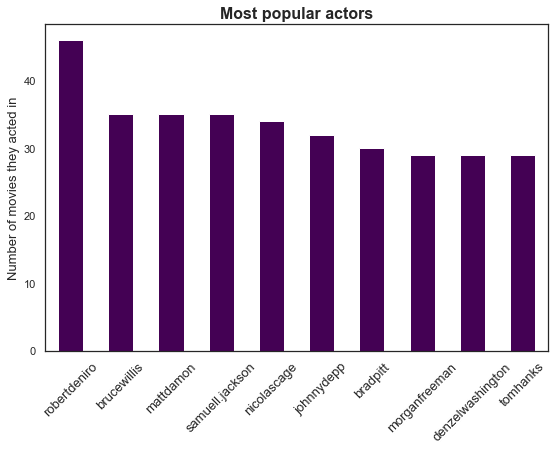

In [13]:
seaborn.set_style('white')
plt.figure(figsize = (9, 6))
plt.title("Most popular actors", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of movies they acted in", fontsize = 13 ) 
movies['main_cast'].explode().value_counts().head(10).plot.bar(cmap = 'viridis')
plt.xticks(rotation=45, fontsize=13)

The most popular actor here is Robert Deniro, who acted in 46 movies.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

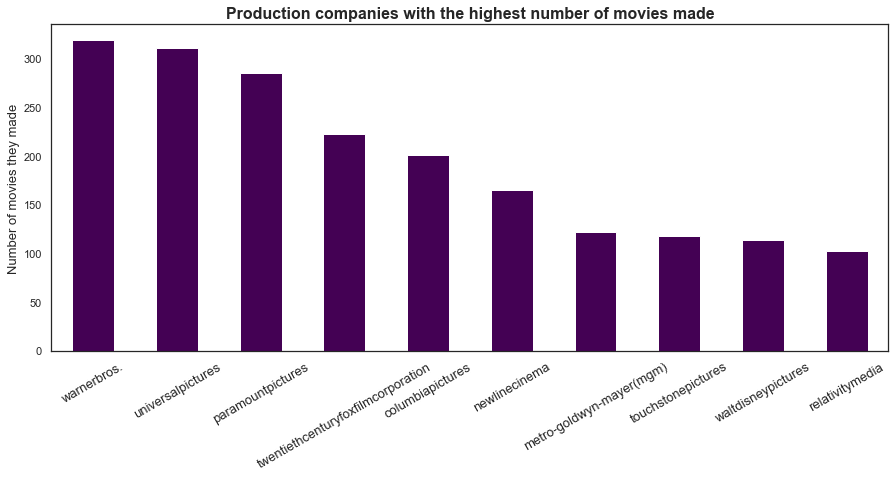

In [14]:
seaborn.set_style('white')
plt.figure(figsize = (15, 6))
plt.title("Production companies with the highest number of movies made", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of movies they made", fontsize = 13 ) 
movies['production_companies'].explode().value_counts().head(10).plot.bar(cmap = 'viridis')
plt.xticks(rotation=30, fontsize=13)

In [15]:
movies[(movies['revenue']==movies['revenue'].max()) | (movies['budget']==movies['budget'].max())]

,budget,genres,id,keywords,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,director,main_cast
0,237000000,"[action, adventure, fantasy, sciencefiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[ingeniousfilmpartners, twentiethcenturyfoxfil...",2009-12-10,2787965087,162.0,"[english, español]",Enter the World of Pandora.,7.2,11800,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]"
17,380000000,"[adventure, action, fantasy]",1865,"[sea, captain, mutiny, sword, primeminister, s...",Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,135.413856,"[waltdisneypictures, jerrybruckheimerfilms, mo...",2011-05-14,1045713802,136.0,"[english, español]",Live Forever Or Die Trying.,6.4,4948,robmarshall,"[johnnydepp, penélopecruz, ianmcshane]"


The most expensive movie here is the "Pirates of the Caribbean: On Stranger Tides", but it is not the most profitable one. The most profitable movie is the "Avatar".

Text(0, 0.5, 'Number of movies')

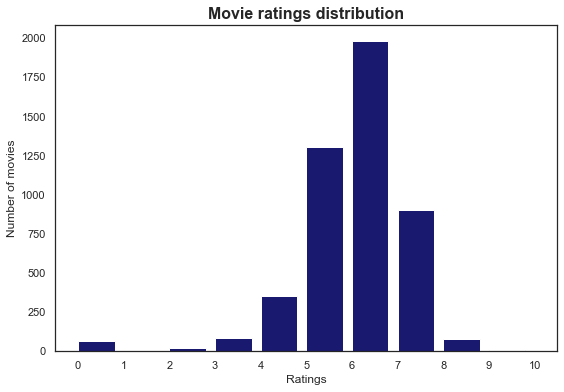

In [16]:
seaborn.set_style('white')
plt.figure(figsize = (9, 6))
plt.hist(movies['vote_average'], bins=10, width=0.8, color='midnightblue')
plt.title("Movie ratings distribution", fontsize = 16, fontweight = "bold")
plt.xlabel("Ratings")
plt.xticks(np.arange(11),np.arange(11))
plt.ylabel("Number of movies")

It seems that most of the movies have a rating of around 6. There seem to be little to no movies rated 1,9 or 10. Also, some movies have no rating at all.

#### Bonus tip: 
Here is a trick I've learned while making this project - obtaining all movies that have a certain actor in the main cast.

In [17]:
idx = movies['main_cast'].explode().loc[movies['main_cast'].explode()=='leonardodicaprio'].index
movies.loc[idx]

,budget,genres,id,keywords,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,director,main_cast
25,200000000,"[drama, romance, thriller]",597,"[shipwreck, iceberg, ship, panic, titanic, oce...",Titanic,"84 years later, a 101-year-old woman named Ros...",100.025899,"[paramountpictures, twentiethcenturyfoxfilmcor...",1997-11-18,1845034188,194.0,"[english, français, deutsch, svenska, italiano...",Nothing on Earth could come between them.,7.5,7562,jamescameron,"[katewinslet, leonardodicaprio, francesfisher]"
49,105000000,"[drama, romance]",64682,"[basedonnovel, infidelity, obsession, hope, 3d]",The Great Gatsby,An adaptation of F. Scott Fitzgerald's Long Is...,61.196071,"[villageroadshowpictures, bazmarkfilms, warner...",2013-05-10,351040419,143.0,[english],Reserving judgments is a matter of infinite ho...,7.3,3769,bazluhrmann,"[leonardodicaprio, tobeymaguire, careymulligan]"
96,160000000,"[action, thriller, sciencefiction, mystery, ad...",27205,"[lossoflover, dream, kidnapping, sleep, subcon...",Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[legendarypictures, warnerbros., syncopy]",2010-07-14,825532764,148.0,"[english, 日本語, français]",Your mind is the scene of the crime.,8.1,13752,christophernolan,"[leonardodicaprio, josephgordon-levitt, ellenp..."
176,135000000,"[western, drama, adventure, thriller]",281957,"[fathersonrelationship, rape, basedonnovel, mo...",The Revenant,"In the 1820s, a frontiersman, Hugh Glass, sets...",100.635882,"[regencyenterprises, appianway, catchplay, ano...",2015-12-25,532950503,156.0,"[english, français]","(n. One who has returned, as if from the dead.)",7.3,6396,alejandrogonzáleziñárritu,"[leonardodicaprio, tomhardy, willpoulter]"
250,116000000,[drama],2567,"[ladykiller, pilot, biography, womanizer, avia...",The Aviator,A biopic depicting the life of filmmaker and a...,45.616098,"[miramaxfilms, appianway, forwardpass, cappapr...",2004-12-17,102000000,170.0,[english],"For some men, the sky was the limit. For him, ...",7.0,1489,martinscorsese,"[leonardodicaprio, cateblanchett, katebeckinsale]"
287,100000000,"[drama, western]",68718,"[bountyhunter, hero, plantation, society, frie...",Django Unchained,"With the help of a German bounty hunter, a fre...",82.121691,"[columbiapictures, theweinsteincompany]",2012-12-25,425368238,165.0,"[english, français, deutsch]","Life, liberty and the pursuit of vengeance.",7.8,10099,quentintarantino,"[jamiefoxx, christophwaltz, leonardodicaprio]"
297,100000000,"[drama, thriller, action]",1372,"[rebel, journalist, journalism, lossoffamily, ...",Blood Diamond,An ex-mercenary turned smuggler. A Mende fishe...,52.792678,"[bedfordfallsproductions, lonelyfilmproduction...",2006-12-07,170877916,143.0,"[afrikaans, english]",It will cost you everything.,7.3,2281,edwardzwick,"[leonardodicaprio, djimonhounsou, jenniferconn..."
298,100000000,"[crime, drama, comedy]",106646,"[corruption, sex, sexuality, bank, humor, biog...",The Wolf of Wall Street,A New York stockbroker refuses to cooperate in...,95.007934,"[paramountpictures, appianway, emjagproduction...",2013-12-25,392000694,180.0,"[français, english]",EARN. SPEND. PARTY.,7.9,6571,martinscorsese,"[leonardodicaprio, jonahhill, margotrobbie]"
316,100000000,"[drama, history, crime]",3131,"[fire, irish-american, immigrant, gangwar, pic...",Gangs of New York,It's 1863. America was born in the streets. Am...,46.160048,"[miramaxfilms, initialentertainmentgroup(ieg),...",2002-12-14,193772504,167.0,"[english, gaeilge, latin, 普通话]",America was born in the streets.,7.1,1910,martinscorsese,"[leonardodicaprio, danielday-lewis, camerondiaz]"
351,90000000,"[drama, thriller, crime]",1422,"[undercover, boston, police, friends, mafia, u...",The Departed,"To take down South Boston's Irish Mafia, the p...",63.429157,"[vertigoentertainment, mediaasiafilms, warnerb...",2006-10-05,289847354,151.0,"[english, 广州话/廣州話]",Lies. Betrayal. Sacrifice.

# Building a model

To build a model, I am going to combine such features as "genres", " keywords", "production companies", "main cast" and "director" into a "metadata soup". Then I am going to feed the soup into a feature extractor, that would tokenize all words from the soup and count the frequency of occurrence of each word. Lastly, I am going to find the most similar movie to a given one using the cosine similarity.

There are 2 vectorizers in sklearn.feature_extraction.text module that could complete the tokenization and counting task:
- CountVectorizer - implements both tokenization and occurrence counting;
- TfidfVectorizer - implements tokenization, occuarnce counting and normalization, using the TfidfTransformer.

The latter is used when dealing with large texts. It can help decrease the weight of frequent but meaningless words, such as articles, and increase the weight of those words that occure less frequent, but may have more value for analyzing. In my case, I don't need to decrease the value of frequent words, so I chose the CountVectorizer.

As a similarity measurement, I chose the cosine_similarity.

In [18]:
def get_soup(x):
    soup = ''
    for i in features:
        if isinstance(x[i], list):
            soup = soup + ' '.join(x[i]) + ' ' 
        elif isinstance(x[i], str):
            soup = soup + x[i]
    return soup

features=['genres', 'keywords', 'production_companies','main_cast','director']
movies['soup'] = movies[features].apply(get_soup,axis=1)

There is a simpler method of creating the soup I found on the Internet, but I decided to keep my own versin of this function. With it I can alter the features I use for the soup in case I want to change them or the dataset changes.

In [19]:
movies['soup'][0]

'action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d ingeniousfilmpartners twentiethcenturyfoxfilmcorporation duneentertainment lightstormentertainment samworthington zoesaldana sigourneyweaver jamescameron'

We can see that the function correctly combined all of the selected features into a single column.

In [20]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

Creating an instance of CountVectorizer() class and feeding it the soup to obtain a term-document matrix, containing all tokens and their frequencies for every movie of the dataset. 

In [21]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

def get_recommendation(title,sim=cosine_sim):
    #Getting the indexes of the movies 
    idx = movies.loc[movies['original_title'] == title].index[0]
    #Getting a list of cosine similarity scores
    sim_scores = list(enumerate(sim[idx]))
    #Sorting by similarity score
    sim_scores.sort(key=lambda x:x[1],reverse=True)
    #Getting 10 movies with the highest similarity scores
    sim_scores = sim_scores[1:11]
    #Getting indexes of those movies
    sim_scores = [i[0] for i in sim_scores]
    return movies['original_title'].iloc[sim_scores]

get_recommendation('The Avengers',cosine_sim)

7                  Avengers: Age of Ultron
85     Captain America: The Winter Soldier
79                              Iron Man 2
182                                Ant-Man
26              Captain America: Civil War
169     Captain America: The First Avenger
68                                Iron Man
126                   Thor: The Dark World
31                              Iron Man 3
129                                   Thor
Name: original_title, dtype: object

When I asked the system to recommend me something similar to "The Avengers", the system gave me the names of other Marvel movies. So I'd say that the system is working properly.

# Conclusion

An <a href="https://towardsdatascience.com/the-remarkable-world-of-recommender-systems-bff4b9cbe6a7">article</a> I found while exploring the topic of recommendation systems highlighted 4 criteria of a recommendation system evaluation:
- Relevance: recommended items must be relevant to the user, otherwise the system's recommendations have no value;
- Novelty: a user is more interested in the items he has not consumed before;
- Serendipity: unexpected yet somewhat similar items have a great value to a user;
- Diversity: items recommended to a user must be diverse, otherwise he will lose interest over time.

Content-based recommendation systems pass on relevance and novelty, because a user may be interested in items with similar atributes. Serendipity is not guaranteed by these systems, but diversity is definitely where they fail. However, this is not a flaw of theirs, because the reason we use content-based recommendation systems is to get similar items. 

There is another type of recommendation systems that can provide diverse but still relevant suggestions to a user, and that is the collaborative recommendation system.